# Imports

In [1]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

import sys, os
sys.path.insert(0, os.path.abspath(".."))

from src.model_comparison import create_memory_cache, train_model, train_with_pca, evaluate
import sklearn
sklearn.set_config(working_memory=12000)

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# No Warnings

In [16]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
sys.stderr = open(os.devnull, 'w')

# Configuration

In [11]:
memory = create_memory_cache()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Load Data

In [4]:
x_train = pd.read_csv("../datasets/x_train_scaled.csv")
x_test = pd.read_csv("../datasets/x_test_scaled.csv")
y_train = pd.read_csv("../datasets/y_train.csv").squeeze()
y_test = pd.read_csv("../datasets/y_test.csv").squeeze()

In [5]:
y_train.value_counts()

label
1    217
0    217
Name: count, dtype: int64

In [6]:
y_test.value_counts()

stroke
0    424
1     26
Name: count, dtype: int64

# MODELS

## SVC

In [12]:
svc_pipeline = Pipeline([('svc', SVC(probability=True))], memory=memory)
svc_params = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['rbf', 'linear'],
    'svc__gamma': ['scale', 'auto']
}
svc_grid, svc_preds = train_model("SVC", svc_pipeline, svc_params, x_train, y_train, x_test, y_test, cv)

🔹 Training SVC...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

SVC
---
Accuracy: 0.7422
F1 Score (macro): 0.5716


## LDA

In [13]:
lda_pipeline = Pipeline([('lda', LDA(solver='lsqr', shrinkage='auto'))], memory=memory)
lda_grid, lda_preds = train_model("LDA", lda_pipeline, {}, x_train, y_train, x_test, y_test, cv)

🔹 Training LDA...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

LDA
---
Accuracy: 0.7244
F1 Score (macro): 0.5544


## Random Forest

In [14]:
rf_pipeline = Pipeline([('rf', RandomForestClassifier(random_state=42))], memory=memory)
rf_params = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2]
}
rf_grid, rf_preds = train_model("Random Forest", rf_pipeline, rf_params, x_train, y_train, x_test, y_test, cv)

🔹 Training Random Forest...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

Random Forest
-------------
Accuracy: 0.7267
F1 Score (macro): 0.5599


## XGBoost

In [17]:
xgb_pipeline = Pipeline([('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))], memory=memory)
xgb_params = {
    'xgb__n_estimators': [100, 200],
    'xgb__max_depth': [3, 6, 9],
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__subsample': [0.8, 1],
    'xgb__colsample_bytree': [0.8, 1]
}
xgb_grid, xgb_preds = train_model("XGBoost", xgb_pipeline, xgb_params, x_train, y_train, x_test, y_test, cv)

🔹 Training XGBoost...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

XGBoost
-------
Accuracy: 0.7267
F1 Score (macro): 0.5599


## Stacking

In [18]:
stacking = StackingClassifier(
    estimators=[
        ('svc', svc_grid.best_estimator_),
        ('rf', rf_grid.best_estimator_),
        ('xgb', xgb_grid.best_estimator_)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=cv,
    n_jobs=-1
)
stacking.fit(x_train, y_train)
stacking_preds = stacking.predict(x_test)
evaluate("Stacking", y_test, stacking_preds)


Stacking
--------
Accuracy: 0.7422
F1 Score (macro): 0.5675


# PCA ANALYSIS


🔵 Training SVC with PCA (5 components)...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

📊 SVC + PCA (5)
----------------------------------------
Accuracy       : 0.6933
F1 Score (macro): 0.5361
Precision       : 0.5754
Recall          : 0.8192

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.68      0.81       424
           1       0.15      0.96      0.27        26

    accuracy                           0.69       450
   macro avg       0.58      0.82      0.54       450
weighted avg       0.95      0.69      0.77       450


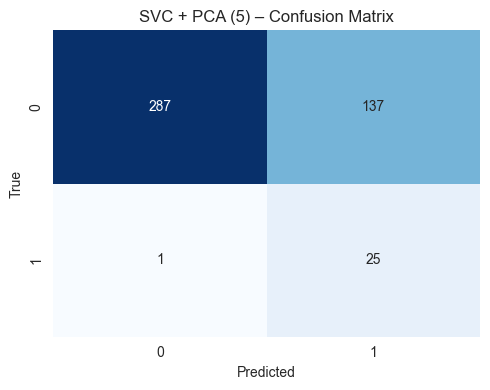


🔵 Training SVC with PCA (10 components)...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

📊 SVC + PCA (10)
----------------------------------------
Accuracy       : 0.7089
F1 Score (macro): 0.5432
Precision       : 0.5751
Recall          : 0.8094

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.70      0.82       424
           1       0.16      0.92      0.27        26

    accuracy                           0.71       450
   macro avg       0.58      0.81      0.54       450
weighted avg       0.94      0.71      0.79       450


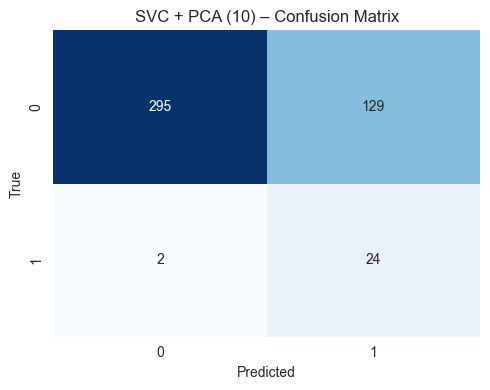


🔵 Training SVC with PCA (11 components)...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

📊 SVC + PCA (11)
----------------------------------------
Accuracy       : 0.6933
F1 Score (macro): 0.5324
Precision       : 0.5716
Recall          : 0.8012

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.68      0.81       424
           1       0.15      0.92      0.26        26

    accuracy                           0.69       450
   macro avg       0.57      0.80      0.53       450
weighted avg       0.94      0.69      0.78       450


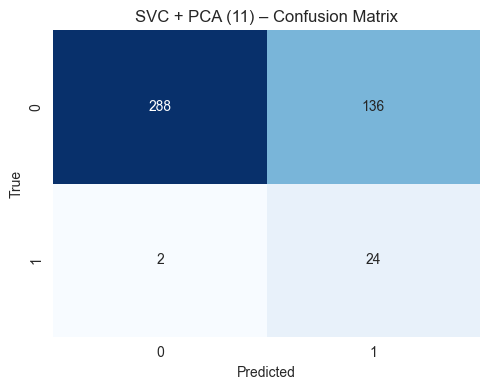


🔵 Training SVC with PCA (12 components)...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

📊 SVC + PCA (12)
----------------------------------------
Accuracy       : 0.6378
F1 Score (macro): 0.4987
Precision       : 0.5649
Recall          : 0.7897

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.62      0.76       424
           1       0.13      0.96      0.23        26

    accuracy                           0.64       450
   macro avg       0.56      0.79      0.50       450
weighted avg       0.95      0.64      0.73       450


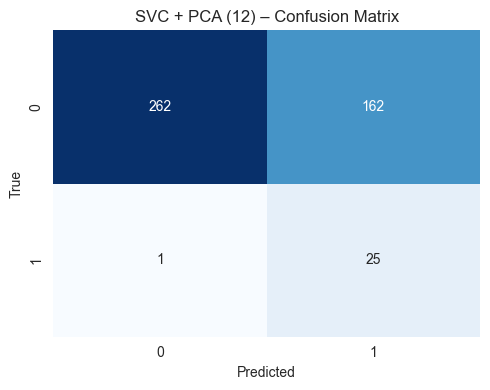


🔵 Training SVC with PCA (13 components)...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

📊 SVC + PCA (13)
----------------------------------------
Accuracy       : 0.7356
F1 Score (macro): 0.5665
Precision       : 0.5858
Recall          : 0.8416

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.72      0.84       424
           1       0.17      0.96      0.30        26

    accuracy                           0.74       450
   macro avg       0.59      0.84      0.57       450
weighted avg       0.95      0.74      0.81       450


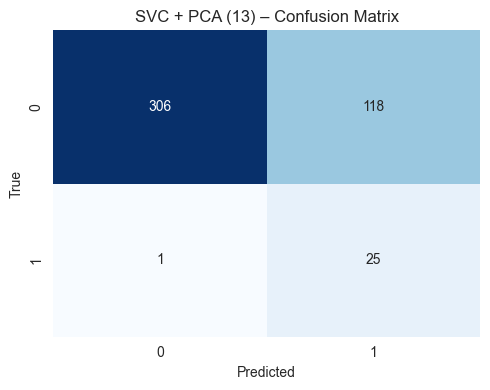


🔵 Training SVC with PCA (14 components)...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

📊 SVC + PCA (14)
----------------------------------------
Accuracy       : 0.7422
F1 Score (macro): 0.5716
Precision       : 0.5877
Recall          : 0.8452

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.73      0.84       424
           1       0.18      0.96      0.30        26

    accuracy                           0.74       450
   macro avg       0.59      0.85      0.57       450
weighted avg       0.95      0.74      0.81       450


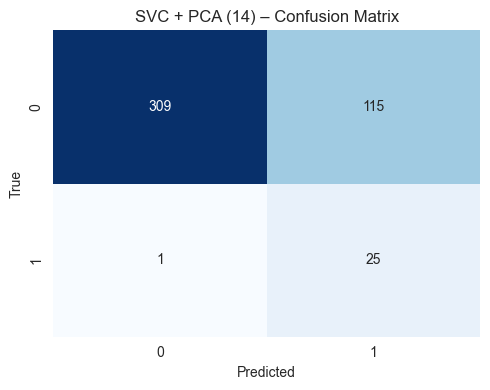


🔵 Training SVC with PCA (15 components)...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

📊 SVC + PCA (15)
----------------------------------------
Accuracy       : 0.7422
F1 Score (macro): 0.5716
Precision       : 0.5877
Recall          : 0.8452

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.73      0.84       424
           1       0.18      0.96      0.30        26

    accuracy                           0.74       450
   macro avg       0.59      0.85      0.57       450
weighted avg       0.95      0.74      0.81       450


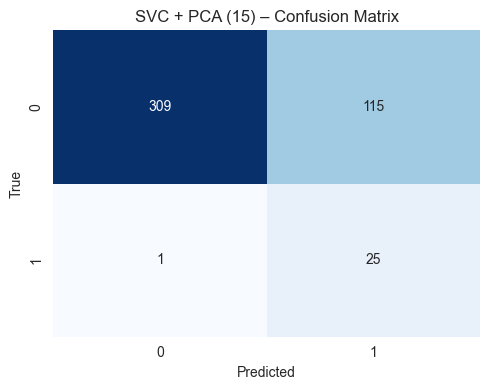


🔵 Training RF with PCA (5 components)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

📊 RF + PCA (5)
----------------------------------------
Accuracy       : 0.7111
F1 Score (macro): 0.5369
Precision       : 0.5677
Recall          : 0.7745

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.70      0.82       424
           1       0.15      0.85      0.25        26

    accuracy                           0.71       450
   macro avg       0.57      0.77      0.54       450
weighted avg       0.94      0.71      0.79       450


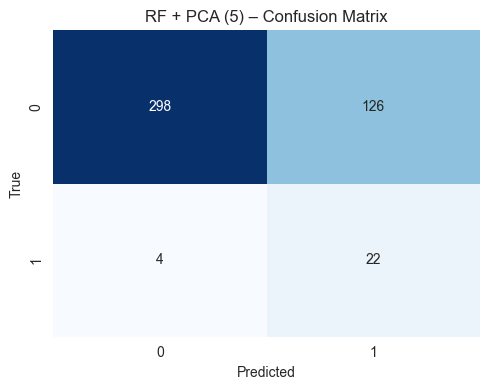


🔵 Training RF with PCA (10 components)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

📊 RF + PCA (10)
----------------------------------------
Accuracy       : 0.7000
F1 Score (macro): 0.5370
Precision       : 0.5730
Recall          : 0.8047

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.69      0.81       424
           1       0.15      0.92      0.26        26

    accuracy                           0.70       450
   macro avg       0.57      0.80      0.54       450
weighted avg       0.94      0.70      0.78       450


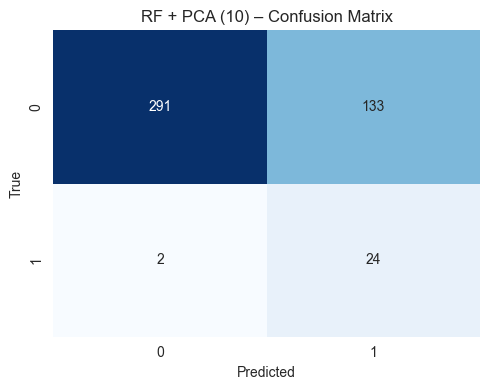


🔵 Training RF with PCA (11 components)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

📊 RF + PCA (11)
----------------------------------------
Accuracy       : 0.7022
F1 Score (macro): 0.5308
Precision       : 0.5657
Recall          : 0.7698

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.69      0.81       424
           1       0.14      0.85      0.25        26

    accuracy                           0.70       450
   macro avg       0.57      0.77      0.53       450
weighted avg       0.94      0.70      0.78       450


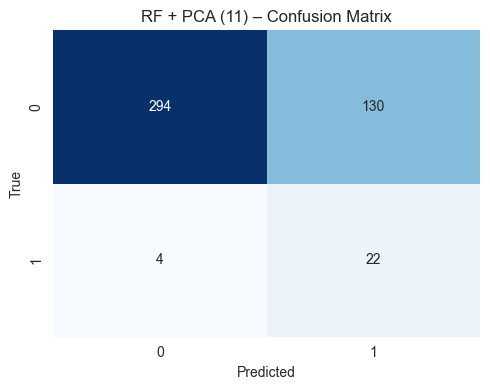


🔵 Training RF with PCA (12 components)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

📊 RF + PCA (12)
----------------------------------------
Accuracy       : 0.7067
F1 Score (macro): 0.5378
Precision       : 0.5706
Recall          : 0.7902

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.70      0.82       424
           1       0.15      0.88      0.26        26

    accuracy                           0.71       450
   macro avg       0.57      0.79      0.54       450
weighted avg       0.94      0.71      0.78       450


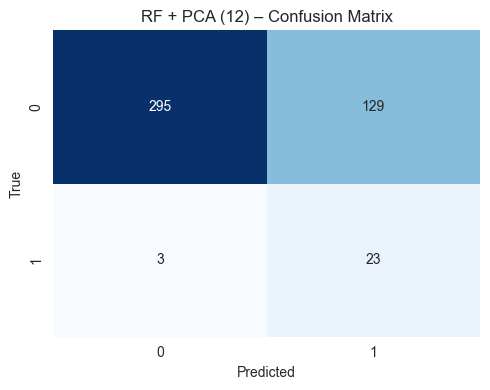


🔵 Training RF with PCA (13 components)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

📊 RF + PCA (13)
----------------------------------------
Accuracy       : 0.7067
F1 Score (macro): 0.5338
Precision       : 0.5667
Recall          : 0.7721

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.70      0.82       424
           1       0.15      0.85      0.25        26

    accuracy                           0.71       450
   macro avg       0.57      0.77      0.53       450
weighted avg       0.94      0.71      0.78       450


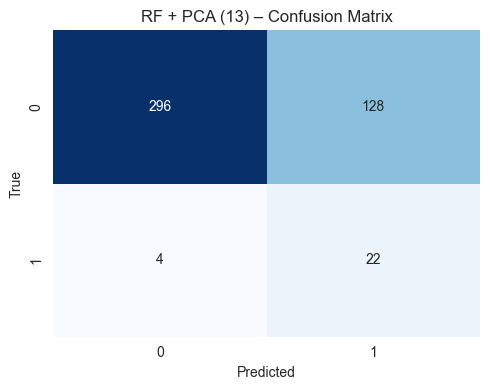


🔵 Training RF with PCA (14 components)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

📊 RF + PCA (14)
----------------------------------------
Accuracy       : 0.7267
F1 Score (macro): 0.5478
Precision       : 0.5715
Recall          : 0.7827

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.72      0.83       424
           1       0.16      0.85      0.26        26

    accuracy                           0.73       450
   macro avg       0.57      0.78      0.55       450
weighted avg       0.94      0.73      0.80       450


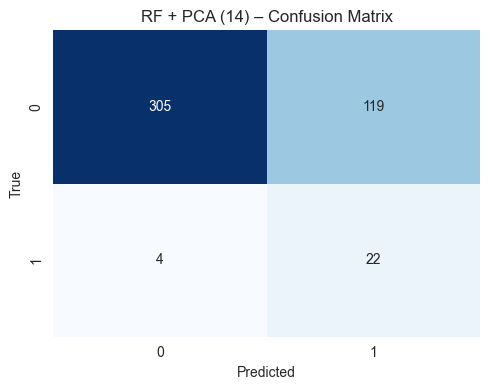


🔵 Training RF with PCA (15 components)...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

📊 RF + PCA (15)
----------------------------------------
Accuracy       : 0.7156
F1 Score (macro): 0.5518
Precision       : 0.5806
Recall          : 0.8310

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.70      0.82       424
           1       0.16      0.96      0.28        26

    accuracy                           0.72       450
   macro avg       0.58      0.83      0.55       450
weighted avg       0.95      0.72      0.79       450


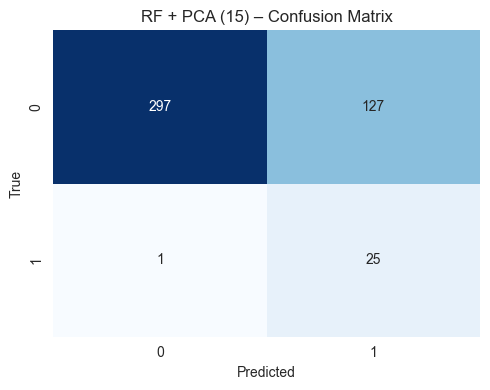


🔵 Training XGB with PCA (5 components)...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

📊 XGB + PCA (5)
----------------------------------------
Accuracy       : 0.7000
F1 Score (macro): 0.5370
Precision       : 0.5730
Recall          : 0.8047

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.69      0.81       424
           1       0.15      0.92      0.26        26

    accuracy                           0.70       450
   macro avg       0.57      0.80      0.54       450
weighted avg       0.94      0.70      0.78       450


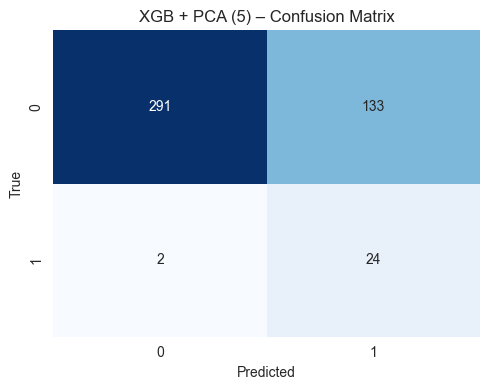


🔵 Training XGB with PCA (10 components)...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

📊 XGB + PCA (10)
----------------------------------------
Accuracy       : 0.7200
F1 Score (macro): 0.5550
Precision       : 0.5817
Recall          : 0.8334

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.71      0.83       424
           1       0.17      0.96      0.28        26

    accuracy                           0.72       450
   macro avg       0.58      0.83      0.56       450
weighted avg       0.95      0.72      0.79       450


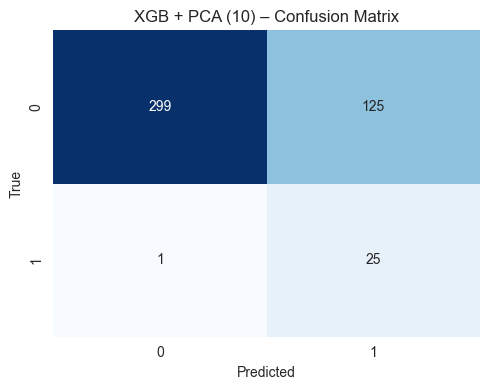


🔵 Training XGB with PCA (11 components)...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

📊 XGB + PCA (11)
----------------------------------------
Accuracy       : 0.7067
F1 Score (macro): 0.5338
Precision       : 0.5667
Recall          : 0.7721

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.70      0.82       424
           1       0.15      0.85      0.25        26

    accuracy                           0.71       450
   macro avg       0.57      0.77      0.53       450
weighted avg       0.94      0.71      0.78       450


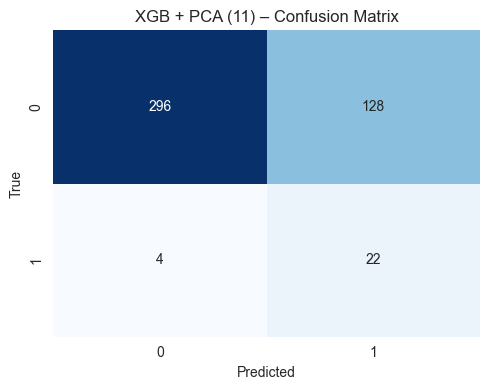


🔵 Training XGB with PCA (12 components)...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

📊 XGB + PCA (12)
----------------------------------------
Accuracy       : 0.7200
F1 Score (macro): 0.5431
Precision       : 0.5699
Recall          : 0.7792

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.71      0.83       424
           1       0.15      0.85      0.26        26

    accuracy                           0.72       450
   macro avg       0.57      0.78      0.54       450
weighted avg       0.94      0.72      0.79       450


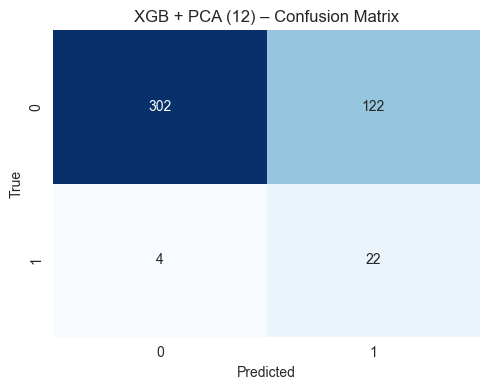


🔵 Training XGB with PCA (13 components)...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

📊 XGB + PCA (13)
----------------------------------------
Accuracy       : 0.7111
F1 Score (macro): 0.5486
Precision       : 0.5795
Recall          : 0.8286

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.70      0.82       424
           1       0.16      0.96      0.28        26

    accuracy                           0.71       450
   macro avg       0.58      0.83      0.55       450
weighted avg       0.95      0.71      0.79       450


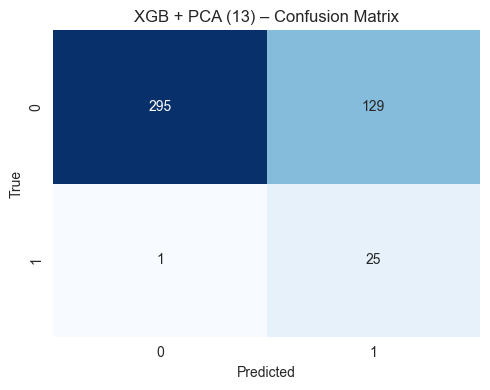


🔵 Training XGB with PCA (14 components)...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

📊 XGB + PCA (14)
----------------------------------------
Accuracy       : 0.7333
F1 Score (macro): 0.5609
Precision       : 0.5813
Recall          : 0.8224

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.72      0.84       424
           1       0.17      0.92      0.29        26

    accuracy                           0.73       450
   macro avg       0.58      0.82      0.56       450
weighted avg       0.95      0.73      0.80       450


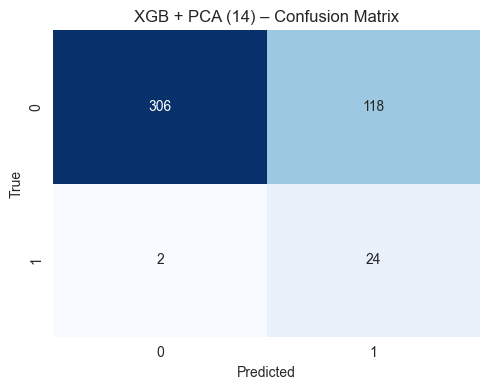


🔵 Training XGB with PCA (15 components)...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

📊 XGB + PCA (15)
----------------------------------------
Accuracy       : 0.7311
F1 Score (macro): 0.5592
Precision       : 0.5807
Recall          : 0.8212

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.72      0.83       424
           1       0.17      0.92      0.28        26

    accuracy                           0.73       450
   macro avg       0.58      0.82      0.56       450
weighted avg       0.95      0.73      0.80       450


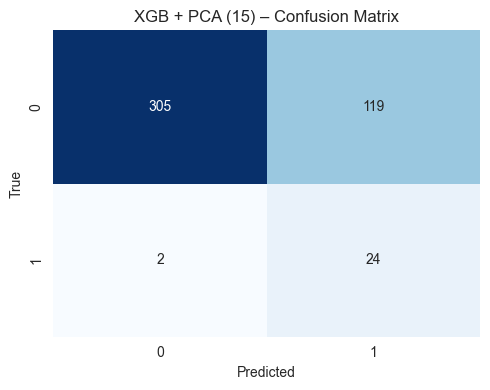

In [19]:
train_with_pca('svc', SVC(probability=True), svc_params, x_train, y_train, x_test, y_test, cv, memory)
train_with_pca('rf', RandomForestClassifier(random_state=42), rf_params, x_train, y_train, x_test, y_test, cv, memory)
train_with_pca('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42), xgb_params, x_train, y_train, x_test, y_test, cv, memory)